# Installation of needed packages

In [2]:
!pip install jupyter_contrib_nbextensions dask modin ray kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Downloading kaggle's taxi trajectory data (2GB)

In [4]:
#copy kaggle.json(credentials) to /root/.kaggle folder
!mkdir /root/.kaggle
!cp -p /content/kaggle.json /root/.kaggle/kaggle.json

#download taxi trajectory dataset dataset
#https://www.kaggle.com/datasets/crailtap/taxi-trajectory
!kaggle datasets download -d "crailtap/taxi-trajectory"

#unzip downloaded data
!unzip taxi-trajectory.zip

!ls -lh

mkdir: cannot create directory ‘/root/.kaggle’: File exists
taxi-trajectory.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  taxi-trajectory.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
total 2.4G
-rw-r--r-- 1 root root   63 Sep 10 23:54 kaggle.json
drwxr-xr-x 1 root root 4.0K Aug 31 13:47 sample_data
-rw-r--r-- 1 root root 516M Sep 11 00:04 taxi-trajectory.zip
-rw-r--r-- 1 root root 1.9G Sep 29  2019 train.csv


# Reading Data

In [8]:
file_name = "train.csv"

In [29]:
read_stats = []
def add_read_stats(name, rows, memory, time):
  read_stats.append({"name": name, "rows": rows, "memory": memory, "time": time})

## 1. Reading data using pandas

In [94]:
import pandas as pd
from time import time



t1 = time()

df = pd.read_csv(file_name)
rows, _ = df.shape
memory = df.memory_usage(deep = True).sum()

t2 = time()

add_read_stats("pandas", rows, memory, t2 - t1)
print(f"ended reading file. It took {t2 - t1} seconds")

ended reading file. It took 26.06625199317932 seconds


## 2. Reading data using dask

In [37]:
from dask import dataframe as dd
import dask

t1 = time()

df = dd.read_csv(file_name)
rows = df.shape[0]
memory = df.memory_usage(deep = True).sum()
d = dask.compute([rows, memory])

t2 = time()
print(f"finished reading {d[0][0]} rows in dask took {t2 - t1} seconds")

add_read_stats("dask", d[0][0], d[0][1], t2 - t1)

finished reading 1710670 rows in dask took 45.84507465362549 seconds


## 3. Reading data using modin

In [32]:
import modin.pandas as mpd

t1 = time()

df = mpd.read_csv(file_name)
rows, _ = df.shape
memory = df.memory_usage(deep = True).sum()

t2 = time()
print(f"finished reading {rows} rows in modin took {t2 - t1} seconds")

add_read_stats("modin", rows, memory, t2 - t1)

(deploy_ray_func pid=1315) tcmalloc: large alloc 1102520320 bytes == 0x87f9c000 @  0x7fa34b0fd615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fa34b53b8c2 0x7fa34b542064 0x7fa34b543e77 0x7fa34b5435f3 0x7fa34b54545a 0x7fa34b54258c 0x7fa34b543b2e 0x7fa34b544fbc 0x7fa34b54258c 0x7fa34b5435f3 0x7fa34b543b2e 0x7fa34b544fbc 0x7fa34b54258c 0x7fa34b543c90 0x7fa34b54545a 0x7fa34b54258c 0x7fa34b543f3c 0x7fa34b54415e 0x7fa34b5442c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576
(deploy_ray_func pid=1474) tcmalloc: large alloc 1102520320 bytes == 0x85da8000 @  0x7fa048e12615 0x592b76 0x4df71e 0x59394f 0x5957cf 0x595b69 0x7fa0492508c2 0x7fa049257064 0x7fa049258e77 0x7fa0492585f3 0x7fa04925a45a 0x7fa04925758c 0x7fa049258b2e 0x7fa049259fbc 0x7fa04925758c 0x7fa0492585f3 0x7fa049258b2e 0x7fa049259fbc 0x7fa04925758c 0x7fa049258c90 0x7fa04925a45a 0x7fa04925758c 0x7fa049258f3c 0x7fa04925915e 0x7fa0492592c7 0x59afff 0x548bbd 0x51566f 0x593dd7 0x511e2c 0x549576


finished reading 1710670 rows in modin took 36.79098200798035 seconds


## 4. Reading data using ray

In [33]:
import ray

t1 = time()

df = ray.data.read_csv(file_name)
rows = df.count()
memory = df.size_bytes()

t2 = time()
print(f"finished reading {rows} rows in ray took {t2 - t1} seconds")

add_read_stats("ray", rows, memory, t2 - t1)

2022-09-11 00:38:42,886	WARNING read_api.py:281 -- ⚠️  The blocks of this dataset are estimated to be 3.0x larger than the target block size of 512 MiB. This may lead to out-of-memory errors during processing. Consider reducing the size of input files or using `.repartition(n)` to increase the number of dataset blocks.


finished reading 1710670 rows in ray took 22.383480072021484 seconds


## Comparing data reading methods

In [38]:
read_stats

[{'name': 'pandas',
  'rows': 1710670,
  'memory': 2184234082,
  'time': 22.711909294128418},
 {'name': 'modin',
  'rows': 1710670,
  'memory': 2184234082,
  'time': 36.79098200798035},
 {'name': 'ray',
  'rows': 1710670,
  'memory': 1911192979,
  'time': 22.383480072021484},
 {'name': 'dask',
  'rows': 1710670,
  'memory': 2184237794,
  'time': 45.84507465362549}]

In [42]:
cleaned = {f"{i['name']}": [i['rows'], i['memory'], i['time']] for i in read_stats}
cleaned = pd.DataFrame.from_dict(cleaned, orient = "index", columns=["rows", "memory", "time"])
cleaned

,rows,memory,time
pandas,1710670,2184234082,22.711909
modin,1710670,2184234082,36.790982
ray,1710670,1911192979,22.383480
dask,1710670,2184237794,45.845075


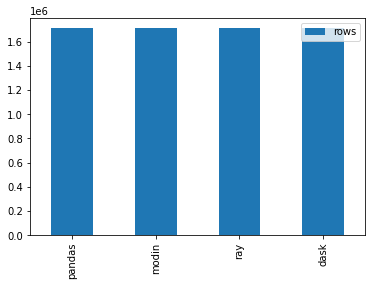

In [45]:
cleaned.plot.bar(y = 'rows')

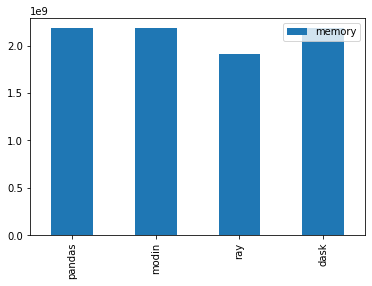

In [46]:
cleaned.plot.bar(y = 'memory')

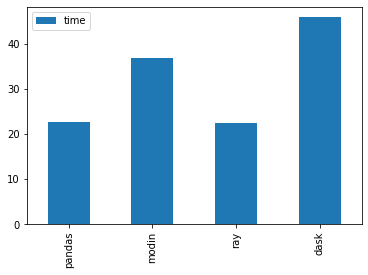

In [47]:
cleaned.plot.bar(y = 'time')

# Columns cleaning

In [74]:
import re
old_columns = df.columns
new_columns = [re.sub(r'(\W)|( )*', "", i).lower() for i in old_columns]
rename_dict = {key: value for key, value in zip(old_columns, new_columns)}
cleaned_df = df.rename(columns=rename_dict)
cleaned_df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Creating yaml file

In [76]:
%%writefile data.yaml
file_type: csv
dataset_name: taxi trajectory
filename: train
table_name:
inbound_delimiter: ","
outbund_delimiter: "|"
skip_leading_rows: 0
columns:
  - trip_id
  - call_type
  - origin_call
  - origin_stand
  - taxi_id
  - timestamp
  - day_type
  - missing_data
  - polyline

Overwriting data.yaml


# Yaml validation

In [81]:
import yaml
with open("data.yaml", "r") as stream:
  data = yaml.safe_load(stream)

yaml_columns = sorted(data['columns'])
columns = sorted(cleaned_df.columns)

yaml_columns == columns

True

# Write file in pipe

In [83]:
cleaned_df.to_csv("train.csv.gz", compression="gzip", sep = "|")
!ls -lh

total 2.4G
-rw-r--r-- 1 root root  277 Sep 11 02:30 data.yaml
-rw-r--r-- 1 root root   63 Sep 10 23:54 kaggle.json
drwxr-xr-x 1 root root 4.0K Aug 31 13:47 sample_data
-rw-r--r-- 1 root root 516M Sep 11 00:04 taxi-trajectory.zip
-rw-r--r-- 1 root root 1.9G Sep 29  2019 train.csv
drwxr-xr-x 2 root root 4.0K Sep 11 02:41 train.csv.gz


In [87]:
!du -sh train.csv.gz

504M	train.csv.gz


# Summarize data

In [98]:
rows, columns = df.shape
file_size = "1.9GB"
memory_size = df.memory_usage(deep = True).sum()
pd.DataFrame([[rows, columns, file_size, memory_size / (1024*1024)]], columns = ["Rows", "Columns", "File_Size", "Memory_Size (MB)"])

,Rows,Columns,File_Size,Memory_Size (MB)
0,1710670,9,1.9GB,2083.047945
